In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip3 install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu128


# Cell 1 - Imports

In [32]:
import random, torch, pickle
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [34]:
with open("addition_dataset.pkl", "rb") as f:
    df = pickle.load(f)

# Cell 2 - Tokenization

In [6]:
SPECIAL = ["<pad>", "<bos>", "<eos>"]
BASE_CHARS = sorted(set("0123456789+= "))
VOCAB = SPECIAL + BASE_CHARS
PAD, BOS, EOS = SPECIAL  # alias pratiques

char2idx = {ch: i for i, ch in enumerate(VOCAB)}
idx2char = {i: ch for ch, i in char2idx.items()}
VOCAB_SIZE = len(VOCAB)

INPUT_LEN = 9                               # « 99 + 99 » => 9 caractères max
OUTPUT_LEN = int(df["output"].str.len().max())  # nb de chiffres de la somme
TGT_LEN = OUTPUT_LEN + 2                    # + BOS + EOS

print("VOCAB_SIZE =", VOCAB_SIZE)
print("OUTPUT_LEN =", OUTPUT_LEN)

VOCAB_SIZE = 16
OUTPUT_LEN = 2


# Cell 3 - Dataset

In [7]:
class AdditionDataset(Dataset):
    def __init__(self, dataframe):
        self.x, self.y, self.meta = [], [], []
        for _, row in dataframe.iterrows():
            inp = row["input"][:INPUT_LEN].ljust(INPUT_LEN)
            out = row["output"][:OUTPUT_LEN].ljust(OUTPUT_LEN)

            src_ids = [char2idx[c] for c in inp]
            tgt_ids = [char2idx[BOS]] + [char2idx[c] for c in out] + [char2idx[EOS]]
            tgt_ids += [char2idx[PAD]] * (TGT_LEN - len(tgt_ids))

            self.x.append(torch.tensor(src_ids, dtype=torch.long))
            self.y.append(torch.tensor(tgt_ids, dtype=torch.long))
            self.meta.append((inp.strip(), out.strip()))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def get_str(self, idx):
        return self.meta[idx]


In [8]:
full_ds = AdditionDataset(df)
train_ds, test_ds = random_split(full_ds, [int(0.8*len(full_ds)), len(full_ds)-int(0.8*len(full_ds))])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=32)

print("Dataset size:", len(full_ds))

Dataset size: 1000


# Cell 4 - Model

In [10]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, n_heads=4, n_layers=2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=char2idx[PAD])
        self.pos = nn.Embedding(512, emb_dim)   # positions jusqu'à 512 tokens

        enc_layer = nn.TransformerEncoderLayer(emb_dim, n_heads, dropout=0.1)
        dec_layer = nn.TransformerDecoderLayer(emb_dim, n_heads, dropout=0.1)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=n_layers)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def add_pos(self, x):
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        return self.emb(x) + self.pos(positions)

    def forward(self, src, tgt):
        src_emb = self.add_pos(src)
        tgt_emb = self.add_pos(tgt)
        memory  = self.encoder(src_emb.permute(1, 0, 2))
        out = self.decoder(tgt_emb.permute(1, 0, 2), memory)
        return self.fc(out.permute(1, 0, 2))

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Seq2SeqTransformer(VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=char2idx[PAD])
print("Device:", device)

c:\Users\Admin\Desktop\test modele bayes\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Device: cuda


# Cell 5 : Setup

In [12]:
EPOCHS = 20
train_losses, test_losses = [], []

for epoch in range(1, EPOCHS+1):
    model.train(); total_tr = 0
    for src, tgt in train_dl:
        src, tgt = src.to(device), tgt.to(device)
        logits = model(src, tgt[:, :-1])
        loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), tgt[:, 1:].reshape(-1))
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_tr += loss.item()
    train_losses.append(total_tr / len(train_dl))

    model.eval(); total_te = 0
    with torch.no_grad():
        for src, tgt in test_dl:
            src, tgt = src.to(device), tgt.to(device)
            logits = model(src, tgt[:, :-1])
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), tgt[:, 1:].reshape(-1))
            total_te += loss.item()
    test_losses.append(total_te / len(test_dl))

    print(f"Epoch {epoch:02d} – Train {train_losses[-1]:.4f} | Test {test_losses[-1]:.4f}")

Epoch 01 – Train 1.0630 | Test 0.0840
Epoch 02 – Train 0.0433 | Test 0.0134
Epoch 03 – Train 0.0129 | Test 0.0073
Epoch 04 – Train 0.0085 | Test 0.0052
Epoch 05 – Train 0.0065 | Test 0.0041
Epoch 06 – Train 0.0054 | Test 0.0034
Epoch 07 – Train 0.0044 | Test 0.0028
Epoch 08 – Train 0.0038 | Test 0.0024
Epoch 09 – Train 0.0033 | Test 0.0020
Epoch 10 – Train 0.0029 | Test 0.0018
Epoch 11 – Train 0.0024 | Test 0.0016
Epoch 12 – Train 0.0022 | Test 0.0014
Epoch 13 – Train 0.0020 | Test 0.0012
Epoch 14 – Train 0.0017 | Test 0.0011
Epoch 15 – Train 0.0016 | Test 0.0010
Epoch 16 – Train 0.0015 | Test 0.0009
Epoch 17 – Train 0.0013 | Test 0.0008
Epoch 18 – Train 0.0012 | Test 0.0008
Epoch 19 – Train 0.0011 | Test 0.0007
Epoch 20 – Train 0.0011 | Test 0.0006


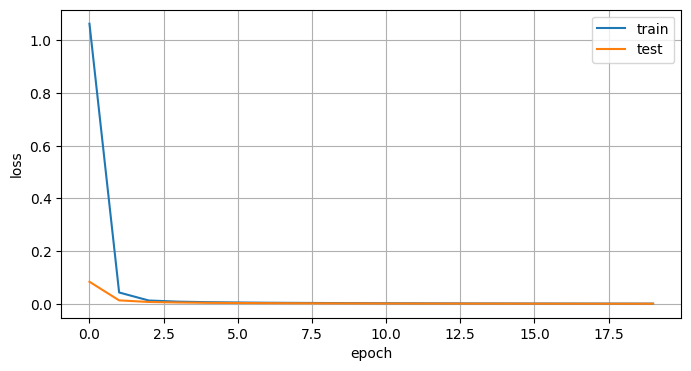

In [13]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train'); plt.plot(test_losses, label='test')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True); plt.legend(); plt.show()

In [14]:
def decode(ids):
    return ''.join(idx2char[i] for i in ids if i in idx2char)

def generate(model, input_str, max_len=OUTPUT_LEN):
    model.eval()
    src_ids = [char2idx[c] for c in input_str[:INPUT_LEN].ljust(INPUT_LEN)]
    src = torch.tensor([src_ids], device=device)

    tgt = torch.tensor([[char2idx[BOS]]], device=device)
    with torch.no_grad():
        for _ in range(max_len + 1):  # +1 pour EOS
            logits = model(src, tgt)
            next_token = logits[:, -1].argmax(-1, keepdim=True)  # (1,1)
            tgt = torch.cat([tgt, next_token], dim=1)
            if next_token.item() == char2idx[EOS]:
                break
    pred = tgt[0, 1:-1].tolist()  # sans BOS/EOS
    return decode(pred)

In [27]:
ex_src, ex_tgt = test_ds[3]
plain_inp, expected = test_ds.dataset.get_str(test_ds.indices[3])
print("Input  :", plain_inp)
print("Target :", expected)
print("Guess  :", generate(model, plain_inp))

Input  : 1 + 6 =
Target : 7
Guess  : 66


In [30]:
def random_tests(n=10):
    """Affiche n exemples pris au hasard dans le jeu de test."""
    n = min(n, len(test_ds))
    indices = random.sample(range(len(test_ds)), n)
    for sub_idx in indices:
        plain_inp, expected = test_ds.dataset.get_str(test_ds.indices[sub_idx])
        guess = generate(model, plain_inp)
        status = "✅" if guess.strip() == expected.strip() else "❌"
        print(f"{plain_inp} = {guess} (attendu {expected}) {status}")

In [31]:
random_tests(10)

46 + 31 = = 66 (attendu 77) ❌
17 + 30 = = 66 (attendu 47) ❌
30 + 29 = = 66 (attendu 59) ❌
27 + 39 = = 66 (attendu 66) ✅
25 + 5 = = 66 (attendu 30) ❌
11 + 17 = = 66 (attendu 28) ❌
13 + 20 = = 66 (attendu 33) ❌
21 + 24 = = 66 (attendu 45) ❌
29 + 9 = = 66 (attendu 38) ❌
0 + 6 = = 66 (attendu 6) ❌
